# Last.fm Data Analysis of Music Listening History

The csv data files were created with [lastfm_downloader.ipynb](lastfm_downloader.ipynb)

---------

In [1]:
import pandas as pd, numpy as np, string, re, pytz
import matplotlib.pyplot as plt, matplotlib.font_manager as fm
from datetime import datetime as dt
%matplotlib inline

In [2]:
# define the fonts to use for plots
family = 'DejaVu Sans'
title_font = fm.FontProperties(family=family, style='normal', size=20, weight='normal', stretch='normal')
label_font = fm.FontProperties(family=family, style='normal', size=16, weight='normal', stretch='normal')
ticks_font = fm.FontProperties(family=family, style='normal', size=12, weight='normal', stretch='normal')
ticks_font_h = fm.FontProperties(family=family, style='normal', size=10.5, weight='normal', stretch='normal')

In [3]:
def get_colors(cmap, n, start=0., stop=1., alpha=1., reverse=False):
    '''return n-length list of rgba colors from the passed colormap name and alpha,
       limit extent by start/stop values and reverse list order if flag is true'''
    import matplotlib.cm as cm, numpy as np
    colors = [cm.get_cmap(cmap)(x) for x in np.linspace(start, stop, n)]
    colors = [(r, g, b, alpha) for r, g, b, _ in colors]
    return list(reversed(colors)) if reverse else colors

## Top artists

In [4]:
artists_most = pd.read_csv('data/lastfm_top_artists.csv', encoding='utf-8')
artists_most = artists_most.set_index('artist')['play_count'].head(25)
artists_most.head()

artist
deadmau5             614
Le Cassette          602
The Midnight         577
Flight Facilities    390
Khruangbin           368
Name: play_count, dtype: int64

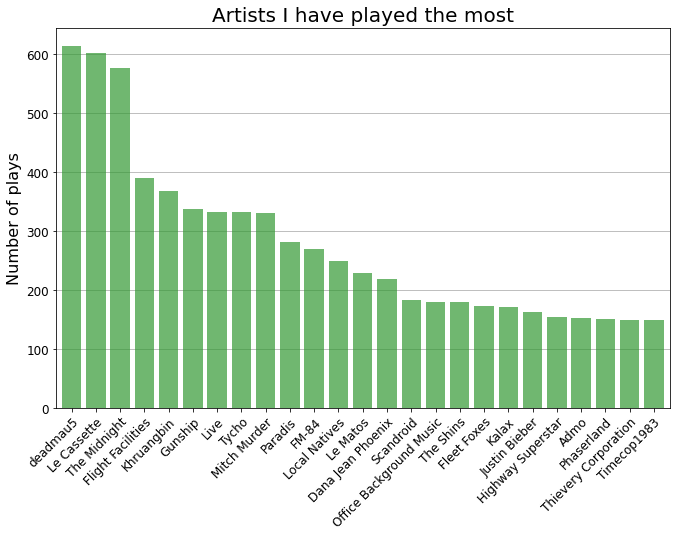

In [5]:
ax = artists_most.plot(kind='bar', figsize=[11, 7], width=0.8, alpha=0.7, color='#339933', edgecolor=None, zorder=2)

ax.yaxis.grid(True)
ax.set_xticklabels(artists_most.index, rotation=45, rotation_mode='anchor', ha='right', fontproperties=ticks_font)
for label in ax.get_yticklabels():
    label.set_fontproperties(ticks_font)

ax.set_title('Artists I have played the most', fontproperties=title_font)
ax.set_xlabel('', fontproperties=label_font)
ax.set_ylabel('Number of plays', fontproperties=label_font)

# plt.savefig('images/lastfm-artists-played-most.png', dpi=96, bbox_inches='tight')
plt.show()

## Top tracks

In [6]:
tracks_most = pd.read_csv('data/lastfm_top_tracks.csv', encoding='utf-8')

def make_label(row, maxlength=30, suffix='...'):
    artist = row['artist']
    track = row['track']
    if len(track) > maxlength:
        track = '{}{}'.format(track[:maxlength-len(suffix)], suffix)
    return '{}\n{}'.format(artist, track)

index = tracks_most.apply(make_label, axis='columns')
tracks_most = tracks_most.set_index(index).drop(labels=['artist', 'track'], axis='columns')
tracks_most = tracks_most['play_count'].head(20)
tracks_most.head()

deadmau5\nHR 8938 Cephei                         215
Le Matos\nCold summer                            149
Admo\nSparks                                     141
Soleil Soleil\nI'm At The Bottom Of The Ocean    112
Men I Trust\nLauren                              107
Name: play_count, dtype: int64

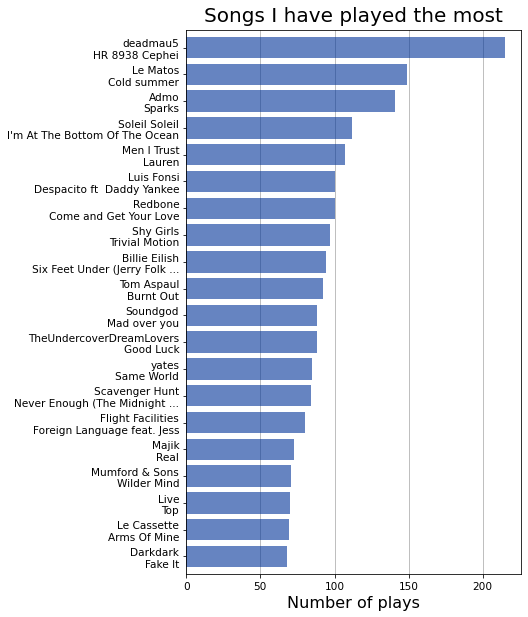

In [7]:
ax = tracks_most.sort_values().plot(kind='barh', figsize=[6, 10], width=0.8, alpha=0.6, 
                                    color='#003399', edgecolor=None, zorder=2)
ax.xaxis.grid(True)
for label in ax.get_xticklabels():
    label.set_fontproperties(ticks_font_h)
for label in ax.get_yticklabels():
    label.set_fontproperties(ticks_font_h)
ax.set_xlabel('Number of plays', fontproperties=label_font)
ax.set_ylabel('', fontproperties=label_font)
ax.set_title('Songs I have played the most', fontproperties=title_font, y=1.005)

# plt.savefig('images/lastfm-tracks-played-most-h.png', dpi=96, bbox_inches='tight')
plt.show()

## Top albums

In [8]:
albums_most = pd.read_csv('data/lastfm_top_albums.csv', encoding='utf-8')

def make_label(row, maxlength=25, suffix='...'):
    artist = row['artist']
    track = row['album']
    if len(track) > maxlength:
        track = '{}{}'.format(track[:maxlength-len(suffix)], suffix)
    return '{}\n{}'.format(artist, track)

index = albums_most.apply(make_label, axis='columns')
albums_most = albums_most.set_index(index).drop(labels=['artist', 'album'], axis='columns')
albums_most = albums_most['play_count'].head(30)
albums_most.head()

Le Cassette\nLeft To Our Own Devices     572
Paradis\nRecto Verso                     277
Live\nThrowing Copper                    270
deadmau5\nW:/2016ALBUM/                  255
Various Artists\nBIRP! September 2014    217
Name: play_count, dtype: int64

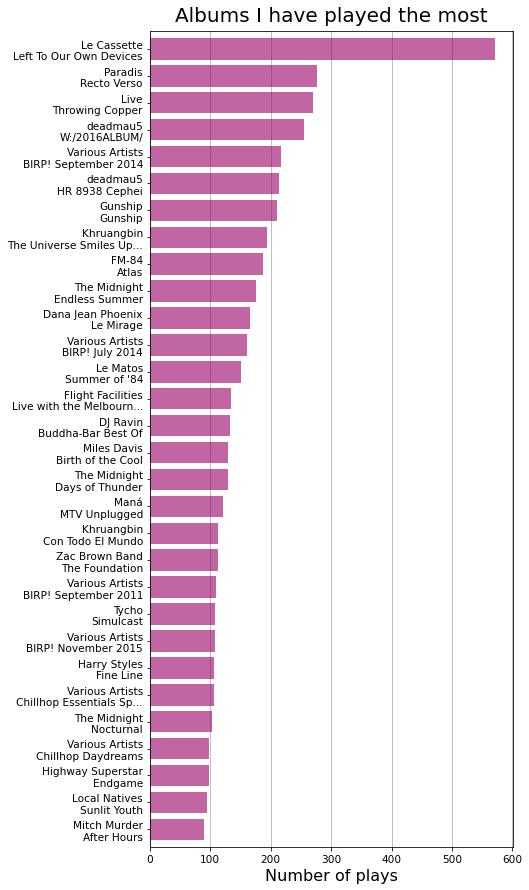

In [9]:
ax = albums_most.sort_values().plot(kind='barh', figsize=[6.5, 15], width=0.8, alpha=0.6, color='#990066', 
                                    edgecolor=None, zorder=2)
ax.xaxis.grid(True)
for label in ax.get_xticklabels():
    label.set_fontproperties(ticks_font_h)
for label in ax.get_yticklabels():
    label.set_fontproperties(ticks_font_h)
ax.set_xlabel('Number of plays', fontproperties=label_font)
ax.set_ylabel('', fontproperties=label_font)
ax.set_title('Albums I have played the most', fontproperties=title_font, y=1.005)

# plt.savefig('images/lastfm-albums-played-most-h.png', dpi=96, bbox_inches='tight')
plt.show()

## All-time scrobbles

In [10]:
# read the all-time scrobbles data set
scrobbles = pd.read_csv('data/lastfm_scrobbles.csv', encoding='utf-8')
scrobbles = scrobbles.drop('timestamp', axis=1)
print('{:,} total scrobbles'.format(len(scrobbles)))
print('{:,} total artists'.format(len(scrobbles['artist'].unique())))

65,063 total scrobbles
9,374 total artists


According to the last.fm web site, I have ~300,000 scrobbles. This API endpoint seems to miss the ones from before 2007.

In [11]:
# convert to datetime
scrobbles['timestamp'] = pd.to_datetime(scrobbles['datetime'])

In [12]:
# reorder and reindex based on date
scrobbles = scrobbles.sort_values(by='timestamp').reset_index(drop=True)
# activities.reset_index(drop=True)

In [13]:
# functions to convert UTC to Shanghai time zone and extract date/time elements
convert_tz = lambda x: x.to_pydatetime().replace(tzinfo=pytz.utc).astimezone(pytz.timezone('Asia/Shanghai'))
get_year = lambda x: convert_tz(x).year
get_month = lambda x: '{}-{:02}'.format(convert_tz(x).year, convert_tz(x).month) #inefficient
get_date = lambda x: '{}-{:02}-{:02}'.format(convert_tz(x).year, convert_tz(x).month, convert_tz(x).day) #inefficient
get_day = lambda x: convert_tz(x).day
get_hour = lambda x: convert_tz(x).hour
get_day_of_week = lambda x: convert_tz(x).weekday()

These lambda functions are inefficient, but necessary to workaround this bug: https://github.com/pydata/pandas/issues/11757. I can update them when the bug is fixed in a future pandas version.

In [14]:
# parse out date and time elements as Shanghai time
scrobbles['year'] = scrobbles['timestamp'].map(get_year)
scrobbles['month'] = scrobbles['timestamp'].map(get_month)
scrobbles['date'] = scrobbles['timestamp'].map(get_date)
scrobbles['day'] = scrobbles['timestamp'].map(get_day)
scrobbles['hour'] = scrobbles['timestamp'].map(get_hour)
scrobbles['dow'] = scrobbles['timestamp'].map(get_day_of_week)
scrobbles = scrobbles.drop(labels=['datetime'], axis=1)

# drop rows with 01-01-1970 as timestamp
scrobbles = scrobbles[scrobbles['year'] > 1970]
scrobbles.head()

,artist,artist_mbid,album,album_mbid,track,track_mbid,timestamp,year,month,date,day,hour,dow
0,Broken Social Scene,2eada8f8-056a-4093-bbc2-004909ce743b,Forgiveness Rock Record,5b6b4697-9151-431a-89bf-351ce9c0e214,World Sick,3c0edcd9-180e-44cd-bb58-def64628839d,2011-08-13 11:15:50,2011,2011-08,2011-08-13,13,19,5
1,Mumford & Sons,c44e9c22-ef82-4a77-9bcd-af6c958446d6,Sigh No More,0af02a32-7deb-3ff0-bbe8-f23a4227494f,Timshel,0c8d80b5-b565-33d2-ac8b-5e57be25ba72,2011-08-13 11:22:39,2011,2011-08,2011-08-13,13,19,5
2,Pomplamoose,63d61461-ecfe-4057-896b-3ba3ff3111eb,BIRP! July 2014,NaN,30 Rock,286aeac5-de64-4873-abac-5091edbde687,2016-08-30 10:44:53,2016,2016-08,2016-08-30,30,18,1
3,Duplekita,e5198716-56da-4040-899b-674e3a088073,BIRP! July 2014,NaN,The Sound of My Name,NaN,2016-08-30 10:47:35,2016,2016-08,2016-08-30,30,18,1
4,Elder Island,c1344d27-2eaf-43e0-a769-9e5285c58866,BIRP! July 2014,NaN,The Big Unknown,c419f3b8-10fe-4b9d-bd83-bd8f6f828af8,2016-08-30 10:55:40,2016,2016-08,2016-08-30,30,18,1


All the last.fm timestamps of my scrobbles appear to be UTC, but the year, month, day, hour columns are now converted to Pacific Time (where I've done nearly all my listening)

## Year-by-year analysis

Visualize the number of scrobbles per year

In [15]:
year_counts = scrobbles['year'].value_counts().sort_index()

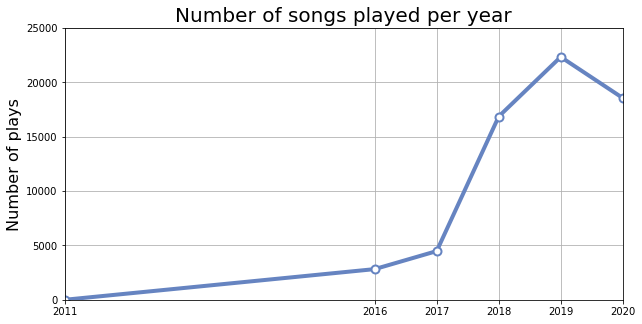

In [16]:
year_counts = scrobbles['year'].value_counts().sort_index()
ax = year_counts.plot(kind='line', figsize=[10, 5], linewidth=4, alpha=1, marker='o', color='#6684c1', 
                      markeredgecolor='#6684c1', markerfacecolor='w', markersize=8, markeredgewidth=2)

ax.set_xlim((year_counts.index[0], year_counts.index[-1]))

ax.yaxis.grid(True)
ax.xaxis.grid(True)
ax.set_ylim(0, 25000)
ax.set_xticks(year_counts.index)
ax.set_ylabel('Number of plays', fontproperties=label_font)
ax.set_xlabel('', fontproperties=label_font)
ax.set_title('Number of songs played per year', fontproperties=title_font)

# plt.savefig('images/lastfm-scrobbles-per-year.png', dpi=96, bbox_inches='tight')
plt.show()

## Month-by-month analysis

Visualize the number of scrobbles per month from 2010 through the present day

In [17]:
# get all the scrobbles from 2010-present
min_year = 2016
scrobbles_10 = scrobbles[scrobbles['year'] >= min_year]
max_year = max(scrobbles_10['year'])

In [18]:
# count number of scrobbles in each month
month_counts = scrobbles_10['month'].value_counts().sort_index()

# not every month necessarily has a scrobble, so fill in missing months with zero counts
date_range = pd.date_range(start=min(scrobbles_10['timestamp']), end=max(scrobbles_10['timestamp']), freq='D')
months_range = date_range.map(lambda x: str(x.date())[:-3])
index = np.unique(months_range)
month_counts = month_counts.reindex(index, fill_value=0)

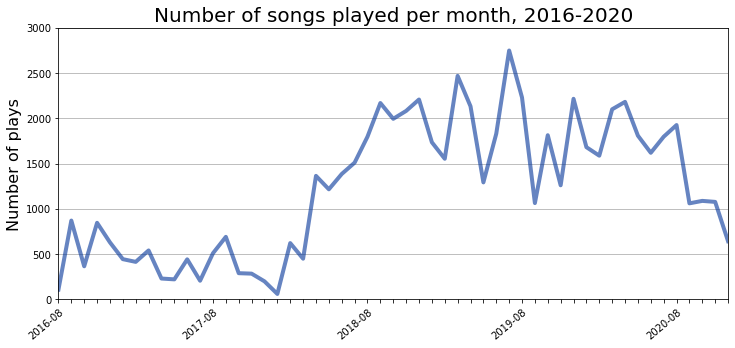

In [19]:
ax = month_counts.plot(kind='line', figsize=[12, 5], linewidth=4, alpha=0.6, color='#003399')

xlabels = month_counts.iloc[range(0, len(month_counts), 12)].index
xlabels = [x if x in xlabels else '' for x in month_counts.index]
ax.set_xticks(range(len(xlabels)))
ax.set_xticklabels(xlabels, rotation=40, rotation_mode='anchor', ha='right')

ax.set_xlim((0, len(month_counts)-1))

ax.yaxis.grid(True)
ax.set_ylim((0,3000))
ax.set_ylabel('Number of plays', fontproperties=label_font)
ax.set_xlabel('', fontproperties=label_font)
ax.set_title('Number of songs played per month, {}-{}'.format(min_year, max_year), fontproperties=title_font)

# plt.savefig('images/lastfm-scrobbles-per-month.png', dpi=96, bbox_inches='tight')
plt.show()

## Day of the week analysis

How many songs have been played on each day of the week?

In [20]:
# get the play count sum by day of the week
dow_counts = scrobbles['dow'].value_counts().sort_index()
dow_counts.index = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

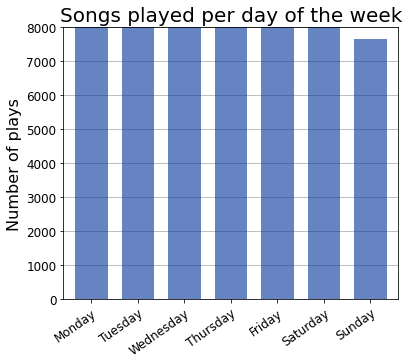

In [21]:
ax = dow_counts.plot(kind='bar', figsize=[6, 5], width=0.7, alpha=0.6, color='#003399', edgecolor=None, zorder=2)

ax.yaxis.grid(True)
ax.set_xticklabels(dow_counts.index, rotation=35, rotation_mode='anchor', ha='right', fontproperties=ticks_font)
for label in ax.get_yticklabels():
    label.set_fontproperties(ticks_font)

ax.set_ylim((0, 8000))
ax.set_title('Songs played per day of the week', fontproperties=title_font)
ax.set_xlabel('', fontproperties=label_font)
ax.set_ylabel('Number of plays', fontproperties=label_font)

# plt.savefig('images/lastfm-scrobbles-per-weekday.png', dpi=96, bbox_inches='tight')
plt.show()

## Hour of the day analysis

How many songs have been played during each hour of the day?

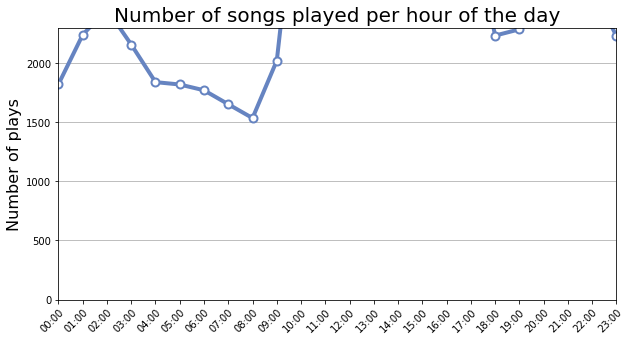

In [22]:
hour_counts = scrobbles['hour'].value_counts().sort_index()
ax = hour_counts.plot(kind='line', figsize=[10, 5], linewidth=4, alpha=1, marker='o', color='#6684c1', 
                      markeredgecolor='#6684c1', markerfacecolor='w', markersize=8, markeredgewidth=2)

xlabels = hour_counts.index.map(lambda x: '{:02}:00'.format(x))
ax.set_xticks(range(len(xlabels)))
ax.set_xticklabels(xlabels, rotation=45, rotation_mode='anchor', ha='right')

ax.set_xlim((hour_counts.index[0], hour_counts.index[-1]))

ax.yaxis.grid(True)
ax.set_ylim((0, 2300))
ax.set_ylabel('Number of plays', fontproperties=label_font)
ax.set_xlabel('', fontproperties=label_font)
ax.set_title('Number of songs played per hour of the day', fontproperties=title_font)

# plt.savefig('images/lastfm-scrobbles-per-hour.png', dpi=96, bbox_inches='tight')
plt.show()

## Analysis by day of the week + hour of the day

How many songs have been played during each hour of the day on each day of the week?

In [23]:
# get the play counts by hour of day and day of week
weekday_hour_counts = scrobbles.groupby(['dow','hour']).count()['track']
hour_numbers = weekday_hour_counts.index.levels[1]
day_numbers = weekday_hour_counts.index.levels[0]
day_names = {0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'}

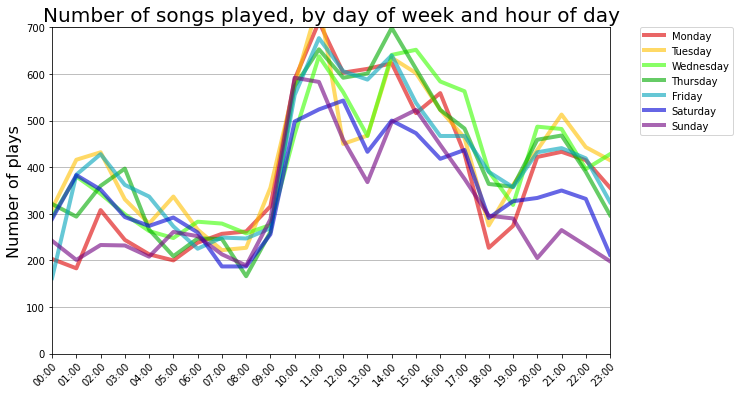

In [24]:
# get one color per day of week
colors = get_colors('nipy_spectral_r', n=len(day_numbers), start=0.1, stop=0.95)

fig, ax = plt.subplots(figsize=[10, 6])
lines = []
for day, c in zip(day_numbers, colors):
    ax = weekday_hour_counts[day].plot(kind='line', linewidth=4, alpha=0.6, c=c)
    lines.append(day_names[day])
    
xlabels = hour_numbers.map(lambda x: '{:02}:00'.format(x))
ax.set_xticks(range(len(xlabels)))
ax.set_xticklabels(xlabels, rotation=45, rotation_mode='anchor', ha='right')

ax.set_xlim((hour_numbers[0], hour_numbers[-1]))

ax.yaxis.grid(True)
ax.set_ylim([0, 700])
ax.set_ylabel('Number of plays', fontproperties=label_font)
ax.set_xlabel('', fontproperties=label_font)
ax.set_title('Number of songs played, by day of week and hour of day', fontproperties=title_font)
ax.legend(lines, loc='upper right', bbox_to_anchor=(1.23,1.017))

# plt.savefig('images/lastfm-scrobbles-days-hours.png', dpi=96, bbox_inches='tight')
plt.show()

## Analysis of a single year (or multiple years)

Add additional years to the 'isin' list to query multiple years.

In [25]:
scrobbles_year = scrobbles[scrobbles['year'].isin([2020])]
len(scrobbles_year)

18565

In [26]:
# what artists did i play the most that year?
artists_year = scrobbles_year['artist'].value_counts()
artists_year = pd.DataFrame(artists_year).reset_index().rename(columns={'artist':'play count', 'index':'artist'})
artists_year.index = [n + 1 for n in artists_year.index]
artists_year.head(10)

,artist,play count
1,deadmau5,242
2,Local Natives,220
3,Office Background Music,180
4,Tycho,168
5,The Weeknd,124
6,Gunship,112
7,Harry Styles,107
8,The Midnight,106
9,L'Impératrice,105
10,Khruangbin,101


In [27]:
# what tracks did i play the most that year?
tracks_year = scrobbles_year.groupby(['artist', 'track']).count().sort_values('timestamp', ascending=False)
tracks_year = tracks_year.reset_index().rename(columns={'timestamp':'play count'})[['artist', 'track', 'play count']]
tracks_year.index = [n + 1 for n in tracks_year.index]
tracks_year.head(10)

,artist,track,play count
1,The Weeknd,Blinding Lights,57
2,Local Natives,Dark Days,49
3,Harry Styles,Watermelon Sugar,39
4,Local Natives,When Am I Gonna Lose You,35
5,Justin Bieber,Intentions (feat. Quavo),27
6,Vulfpeck,Back Pocket,26
7,deadmau5,Let Go,23
8,FM-84,Running in the Night,22
9,Sepalot,Rainbows - Live,22
10,deadmau5,HR 8938 Cephei,21


In [28]:
# what albums did i play the most that year?
albums_year = scrobbles_year.groupby(['artist', 'album']).count().sort_values('timestamp', ascending=False)
albums_year = albums_year.reset_index().rename(columns={'timestamp':'play count'})[['artist', 'album', 'play count']]
albums_year.index = [n + 1 for n in albums_year.index]

# remove text in parentheses or brackets
regex = re.compile('\\(.*\\)|\\[.*]')
albums_year['album'] = albums_year['album'].map(lambda x: regex.sub('', x))
albums_year.head(10)

,artist,album,play count
1,deadmau5,W:/2016ALBUM/,150
2,Harry Styles,Fine Line,106
3,Tycho,Simulcast,104
4,Paradis,Recto Verso,83
5,The Weeknd,After Hours,80
6,Local Natives,Sunlit Youth,77
7,Gunship,Gunship,66
8,FM-84,Atlas,65
9,Justin Bieber,Changes,60
10,Local Natives,VIOLET STREET,56


## Analysis of a single month (or multiple months)

Add additional months to the 'isin' list to query multiple months.

In [29]:
scrobbles_month = scrobbles[scrobbles['month'].isin(['2018-06'])]
len(scrobbles_month)

1385

In [30]:
# what artists did i play the most that month?
artists_month = scrobbles_month['artist'].value_counts()
artists_month = pd.DataFrame(artists_month).reset_index().rename(columns={'artist':'play count', 'index':'artist'})
artists_month.index = [n + 1 for n in artists_month.index]
artists_month.head(10)

,artist,play count
1,Mitch Murder,66
2,Phaserland,26
3,The Midnight,24
4,Alexandros,23
5,FM-84,22
6,Maroon 5,22
7,Brian Eno,21
8,Neon Nox,18
9,Intelligence Dept.,17
10,Timecop1983,15


In [31]:
# what tracks did i play the most that month?
tracks_month = scrobbles_month.groupby(['artist', 'track']).count().sort_values('timestamp', ascending=False)
tracks_month = tracks_month.reset_index().rename(columns={'timestamp':'play count'})[['artist', 'track', 'play count']]
tracks_month.index = [n + 1 for n in tracks_month.index]
tracks_month.head(10)

,artist,track,play count
1,Maroon 5,What Lovers Do (feat. SZA),12
2,Timecop1983,River of Darkness,11
3,Neon Nox,Checkpoint - Original Mix,11
4,Mitch Murder,Coup De Théâtre,9
5,The Midnight,Days of Thunder,9
6,Phaserland,Hot Stunner (feat. Nikki Dodds),8
7,Highway Superstar,Hunters,8
8,Mitch Murder,After Hours Run,8
9,Mitch Murder,Bertone's Theme,8
10,Sebastian Gampl,One On One (feat. Tommy Reeve),8


In [32]:
# what albums did i play the most that month?
albums_month = scrobbles_month.groupby(['artist', 'album']).count().sort_values('timestamp', ascending=False)
albums_month = albums_month.reset_index().rename(columns={'timestamp':'play count'})[['artist', 'album', 'play count']]
albums_month.index = [n + 1 for n in albums_month.index]
albums_month.head(10)

,artist,album,play count
1,Mitch Murder,After Hours,53
2,Alexandros,data,23
3,Maroon 5,Red Pill Blues (Deluxe),19
4,Phaserland,Electric Atlantic,17
5,Intelligence Dept.,Sleeping City,17
6,A Perfect Circle,Mer de noms,14
7,FM-84,Atlas,14
8,Radiohead,In Rainbows,13
9,Neon Nox,Unfinished Business,12
10,The Midnight,Days of Thunder,11


## Listening history of a specific artist, album, or track

See the last 5 times I've listened to someone or something

In [33]:
# when were the last 5 times I played something by Midlake?
scrobbles[scrobbles['artist'].str.contains('Midlake')].head()

,artist,artist_mbid,album,album_mbid,track,track_mbid,timestamp,year,month,date,day,hour,dow
2946,Midlake,da90b5da-349e-4906-a0b4-805f5e46190d,Trials of Van Occupanther,NaN,Roscoe,08ca07a6-6314-3ded-86cc-ddfc487276b2,2017-01-03 06:24:39,2017,2017-01,2017-01-03,3,14,1
2947,Midlake,da90b5da-349e-4906-a0b4-805f5e46190d,Trials of Van Occupanther,NaN,Roscoe,08ca07a6-6314-3ded-86cc-ddfc487276b2,2017-01-03 06:29:28,2017,2017-01,2017-01-03,3,14,1
2948,Midlake,da90b5da-349e-4906-a0b4-805f5e46190d,Trials of Van Occupanther,NaN,Roscoe,08ca07a6-6314-3ded-86cc-ddfc487276b2,2017-01-03 06:34:18,2017,2017-01,2017-01-03,3,14,1
2949,Midlake,da90b5da-349e-4906-a0b4-805f5e46190d,Trials of Van Occupanther,NaN,Roscoe,08ca07a6-6314-3ded-86cc-ddfc487276b2,2017-01-03 06:39:07,2017,2017-01,2017-01-03,3,14,1
6157,Midlake,da90b5da-349e-4906-a0b4-805f5e46190d,Trials of Van Occupanther,NaN,Roscoe,08ca07a6-6314-3ded-86cc-ddfc487276b2,2017-09-09 09:15:40,2017,2017-09,2017-09-09,9,17,5


In [34]:
# when were the last 5 times I played something off of a Greatest Hits Album?
scrobbles[scrobbles['album'].fillna('').str.contains('Greatest Hits')].head()

,artist,artist_mbid,album,album_mbid,track,track_mbid,timestamp,year,month,date,day,hour,dow
942,Journey,NaN,Greatest Hits,03ffc721-3d27-4fb9-a394-c06da971ee5b,Send Her My Love,0172cc84-64de-3c08-b82b-91182c7841ef,2016-09-27 16:39:00,2016,2016-09,2016-09-28,28,0,2
990,Journey,NaN,Greatest Hits,03ffc721-3d27-4fb9-a394-c06da971ee5b,Lovin' Touchin' Squeezin',NaN,2016-10-05 09:57:52,2016,2016-10,2016-10-05,5,17,2
991,Journey,NaN,Greatest Hits,03ffc721-3d27-4fb9-a394-c06da971ee5b,Lights,050900e1-65e3-3f78-bbd2-433b5760ba74,2016-10-05 10:01:47,2016,2016-10,2016-10-05,5,18,2
992,Journey,NaN,Greatest Hits,03ffc721-3d27-4fb9-a394-c06da971ee5b,Ask the Lonely,00ce7b93-3b38-35de-a1b2-cade3fd71709,2016-10-05 10:04:58,2016,2016-10,2016-10-05,5,18,2
993,Journey,NaN,Greatest Hits,03ffc721-3d27-4fb9-a394-c06da971ee5b,Separate Ways (Worlds Apart),022eb4cc-d6e6-496b-8154-9293e9161436,2016-10-05 10:08:53,2016,2016-10,2016-10-05,5,18,2


In [35]:
# when were the last 5 times I played Maneater?
scrobbles[scrobbles['track'].str.contains('Maneater')].head()

,artist,artist_mbid,album,album_mbid,track,track_mbid,timestamp,year,month,date,day,hour,dow
1200,Hall & Oates,NaN,NaN,NaN,Maneater (The Apple Scruffs Mix),NaN,2016-10-21 08:05:04,2016,2016-10,2016-10-21,21,16,4
1239,Hall & Oates,NaN,NaN,NaN,Maneater (The Apple Scruffs Mix),NaN,2016-10-24 08:33:44,2016,2016-10,2016-10-24,24,16,0
1254,Hall & Oates,NaN,NaN,NaN,Maneater (The Apple Scruffs Mix),NaN,2016-10-25 08:46:27,2016,2016-10,2016-10-25,25,16,1
1257,Hall & Oates,NaN,NaN,NaN,Maneater (The Apple Scruffs Mix),NaN,2016-10-26 08:15:07,2016,2016-10,2016-10-26,26,16,2
1368,Hall & Oates,NaN,NaN,NaN,Maneater (The Apple Scruffs Mix),NaN,2016-11-02 07:52:08,2016,2016-11,2016-11-02,2,15,2


## Visualize top artists over time

How have the cumulative plays of most listened-to artists changed over time?

In [36]:
# get the cumulative play counts since 2009 for the top n most listened-to artists
n = 6
plays = scrobbles[scrobbles['artist'].isin(artists_most.head(n).index)]
plays = plays[plays['year'] >= 2009]
plays = plays.groupby(['artist','year']).count().groupby(level=[0]).cumsum()['track']

# make sure we have each year represented for each artist, even if they got no plays that year
plays = plays.unstack().T.fillna(method='ffill').T.stack()
top_artists = plays.index.levels[0]

<ipython-input-37-2ffbeb2cd55a>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(plays.index.levels[1], rotation=0, rotation_mode='anchor', ha='center')


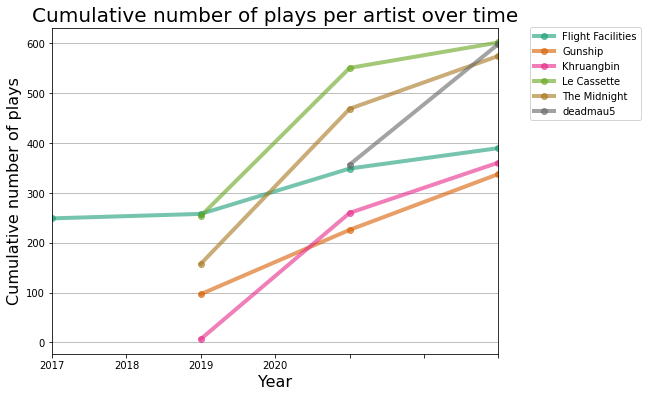

In [37]:
# get one color per artist
colors = get_colors('Dark2', n)

fig, ax = plt.subplots(figsize=[8, 6])
lines = []
for artist, c in zip(top_artists, colors):
    ax = plays[artist].plot(kind='line', linewidth=4, alpha=0.6, marker='o', c=c)
    lines.append(artist)
    
ax.set_xlim((plays.index.get_level_values(1).min(), plays.index.get_level_values(1).max()))

ax.yaxis.grid(True)
ax.set_xticklabels(plays.index.levels[1], rotation=0, rotation_mode='anchor', ha='center')
ax.set_ylabel('Cumulative number of plays', fontproperties=label_font)
ax.set_xlabel('Year', fontproperties=label_font)
ax.set_title('Cumulative number of plays per artist over time', fontproperties=title_font)
ax.legend(lines, loc='upper right', bbox_to_anchor=(1.33, 1.016))

# plt.savefig('images/lastfm-scrobbles-top-artists-years.png', dpi=96, bbox_inches='tight')
plt.show()

## Characteristics of artists' names

Text analysis of artist name strings

In [38]:
# remove 'The ' and 'A ' preceding artist names, get unique set of names, then get first letter frequency
artists_clean = scrobbles['artist'].str.replace('The ','').str.replace('A ','')
first_letters = pd.Series(artists_clean.unique()).map(lambda x: x.upper()[0]).value_counts()
first_letters = first_letters[[c for c in string.ascii_uppercase]]

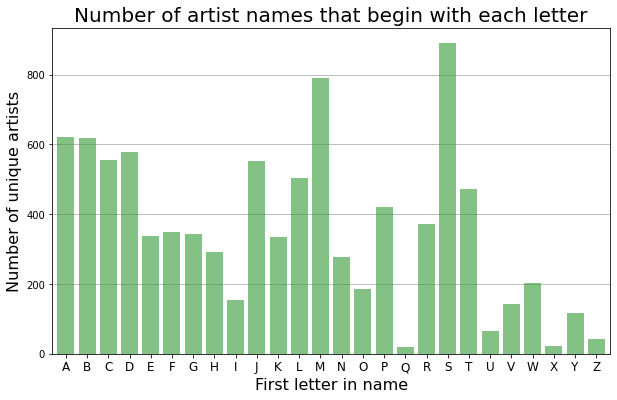

In [39]:
# plot the frequency of artist names that begin with each letter
ax = first_letters.plot(kind='bar', figsize=[10, 6], width=0.8, alpha=0.6, color='#339933', edgecolor=None, zorder=2)
ax.yaxis.grid(True)
ax.set_xticklabels(first_letters.index, rotation=0, rotation_mode='anchor', ha='center', fontproperties=ticks_font)

ax.set_title('Number of artist names that begin with each letter', fontproperties=title_font)
ax.set_xlabel('First letter in name', fontproperties=label_font)
ax.set_ylabel('Number of unique artists', fontproperties=label_font)

# plt.savefig('images/lastfm-artists-first-letter-count.png', dpi=96, bbox_inches='tight')
plt.show()

In [40]:
# which artist names begin with the letter 'X'?
str(list(pd.Series(artists_clean[artists_clean.str.upper().str.startswith('X')].unique())))

"['xx', 'Xavier Luna', 'XTC', 'XXYYXX', 'xJK.', 'Ximena Sariñana', 'xxweesh', 'Xori', 'Xander', 'Xzavier Stone', 'X Ambassadors', 'Xavia', 'Xenturion Prime', 'Xu Jiangde', 'Xique-Xique', 'Xinobi', 'Xetrovoid', 'Xander.', 'Xavier Hermenegildo', 'Xyla', 'Xavier Davis', 'X.Y.R.']"

In [41]:
# what are the most common first words in artist names that begin with 'M'?
artists_m = pd.Series(artists_clean[artists_clean.str.upper().str.startswith('M')].unique())
artists_m.map(lambda x: x.split()[0]).value_counts().head(15)

Michael     22
Matt        17
Mr.         15
Max         11
Mark         8
Marc         8
Midnight     8
My           7
Mr           7
Mary         7
Matthew      6
Martin       6
Moon         5
Magic        5
Marcus       5
dtype: int64

In [42]:
# what are the most common first words in all the artist names?
pd.Series(scrobbles['artist'].unique()).map(lambda x: x.split()[0].lower()).value_counts().head(15)

the        400
dj          37
david       32
john        30
michael     24
tom         21
alex        20
james       18
peter       18
ben         18
chris       17
matt        17
a           17
mr.         16
george      16
dtype: int64

In [43]:
# what are the most common words in all the artist names, anywhere in the name?
word_list = []
stop_list = ['&','the','and','of','a','in','for','la','los','el','de','y']
for artist in artists_clean.unique():
    for word in artist.split():
        word_list.append(word.lower())

word_list = [word for word in word_list if word not in stop_list]
pd.Series(word_list).value_counts().head(15)

david        39
john         38
dj           38
james        36
band         33
orchestra    31
black        29
michael      28
trio         27
brown        25
club         25
alex         24
brothers     22
ben          22
tom          22
dtype: int64

In [44]:
# what is the longest artist name?
print('"{}"'.format(max(artists_clean, key=len)))

"Deep Breath Calming Down Buddha Healing Meditation Music"


In [45]:
# what is the distribution of lengths of artist names (up to n number of characters)?
n = 50
name_lengths = pd.Series([len(artist) for artist in artists_clean.unique()])
name_lengths = name_lengths.value_counts().sort_index()
name_lengths = name_lengths.iloc[0:n+1].reindex(range(n+1), fill_value=0)

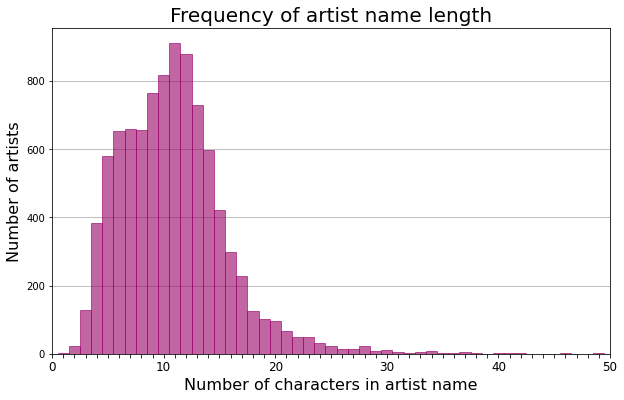

In [46]:
ax = name_lengths.plot(kind='bar', figsize=(10,6), alpha=0.6, width=1, color='#990066', edgecolor='#990066', zorder=2)

xlabels = [x if x % 10 == 0 else '' for x in name_lengths.index]
ax.set_xticklabels(xlabels, rotation=0, rotation_mode='anchor', ha='center', fontproperties=ticks_font)
ax.yaxis.grid(True)
ax.set_xlim((0,n))

ax.set_title('Frequency of artist name length', fontproperties=title_font)
ax.set_xlabel('Number of characters in artist name', fontproperties=label_font)
ax.set_ylabel('Number of artists', fontproperties=label_font)

# plt.savefig('images/lastfm-artists-name-length.png', dpi=96, bbox_inches='tight')
plt.show()

# Checking for Duplicates

In [47]:
len(scrobbles[scrobbles.duplicated() == True])

0

In [48]:
scrobbles[scrobbles.duplicated() == True].head() # single duplicate

,artist,artist_mbid,album,album_mbid,track,track_mbid,timestamp,year,month,date,day,hour,dow


In [49]:
# when were the last 5 times I played something by My Bloody Valentine?
scrobbles[scrobbles['artist'].str.contains('Mariza')].head()

,artist,artist_mbid,album,album_mbid,track,track_mbid,timestamp,year,month,date,day,hour,dow
1954,Mariza,8cbb4d57-f44d-433a-90bf-a0892af886e1,Transparente,68d8d045-630b-3ba5-8ab9-0b7929625706,Fado Tordo,0ad3f727-5718-3267-b580-7f26c4bc8121,2016-11-20 06:45:24,2016,2016-11,2016-11-20,20,14,6
1958,Mariza,NaN,Fado Em Mim,46877462-7cff-41c5-a3f0-1dd60966c453,O Gente Da Minha Terra,NaN,2016-11-20 06:56:27,2016,2016-11,2016-11-20,20,14,6
1961,Mariza,8cbb4d57-f44d-433a-90bf-a0892af886e1,Transparente,68d8d045-630b-3ba5-8ab9-0b7929625706,Recusa,68d51038-cc37-49ad-8581-30827df2d22c,2016-11-20 07:10:58,2016,2016-11,2016-11-20,20,15,6
1963,Mariza,8cbb4d57-f44d-433a-90bf-a0892af886e1,Fado Em Mim,46877462-7cff-41c5-a3f0-1dd60966c453,Chuva,164be019-ad69-3eee-b3bc-929ea013c3b9,2016-11-20 07:17:18,2016,2016-11,2016-11-20,20,15,6
1964,Mariza,8cbb4d57-f44d-433a-90bf-a0892af886e1,Fado Em Mim,46877462-7cff-41c5-a3f0-1dd60966c453,Maria Lisboa,3aa98bf6-44cc-34fc-a4a3-f332dab38c88,2016-11-20 07:21:23,2016,2016-11,2016-11-20,20,15,6


# Monthly Review: Music Listening

In [50]:
targetMonth = '2020-04' # edit month here
scrobbles_month = scrobbles[scrobbles['month'].isin([targetMonth])]
len(scrobbles_month)

2181

In [51]:
# listening during which hours
len(scrobbles_month.hour.unique())

20

In [52]:
# what artists did i play the most that month?
artists_month = scrobbles_month['artist'].value_counts()
artists_month = pd.DataFrame(artists_month).reset_index().rename(columns={'artist':'play count', 'index':'artist'})
artists_month.index = [n + 1 for n in artists_month.index]
artists_month.head(10)

,artist,play count
1,Local Natives,122
2,Gunship,68
3,The Weeknd,47
4,Nujabes,43
5,Simon & Garfunkel,31
6,Tycho,24
7,Maiwan,16
8,Led Zeppelin,16
9,Pet Shop Boys,15
10,Dye O,13


In [53]:
# what tracks did i play the most that month?
tracks_month = scrobbles_month.groupby(['artist', 'track']).count().sort_values('timestamp', ascending=False)
tracks_month = tracks_month.reset_index().rename(columns={'timestamp':'play count'})[['artist', 'track', 'play count']]
tracks_month.index = [n + 1 for n in tracks_month.index]
tracks_month.head(10)

,artist,track,play count
1,Local Natives,Dark Days,24
2,The Weeknd,Blinding Lights,22
3,Local Natives,When Am I Gonna Lose You,16
4,Local Natives,Wide Eyes,9
5,Local Natives,Coins,9
6,Local Natives,I Saw You Close Your Eyes,8
7,The Weeknd,In Your Eyes,8
8,Jacob Groening,Kanun - Original Mix,6
9,Local Natives,Megaton Mile,6
10,Gunship,Pink Mist,6


In [54]:
# what albums did i play the most that month?
albums_month = scrobbles_month.groupby(['artist', 'album']).count().sort_values('timestamp', ascending=False)
albums_month = albums_month.reset_index().rename(columns={'timestamp':'play count'})[['artist', 'album', 'play count']]
albums_month.index = [n + 1 for n in albums_month.index]
albums_month.head(10)

,artist,album,play count
1,Local Natives,Sunlit Youth,41
2,Gunship,Gunship,38
3,The Weeknd,After Hours,36
4,Local Natives,VIOLET STREET,31
5,Gunship,Dark All Day,28
6,Nujabes,Modal Soul,20
7,Local Natives,Gorilla Manor,18
8,Live,Throwing Copper,13
9,Paradis,Recto Verso,12
10,Nujabes,Metaphorical Music,11


In [55]:
# listening days
listeningDays = len(scrobbles_month.day.unique())

In [56]:
# percentage of listening days in month
# total days in month
from datetime import datetime
dt = datetime.strptime(targetMonth, '%Y-%m')
from calendar import monthrange
round((listeningDays / monthrange(dt.year, dt.month)[1]), 3)

1.0

In [57]:
scrobbles_month['hour'].head()

51865    2
51866    2
51867    2
51868    4
51869    4
Name: hour, dtype: int64

In [58]:
hour_counts = scrobbles_month['hour'].value_counts().sort_index()
hour_counts

0      85
1     109
2     216
3     170
4      95
5     161
6     145
7     123
8      91
9     122
10     90
11    105
12    172
13    218
14    160
15     64
16      3
21      1
22      7
23     44
Name: hour, dtype: int64

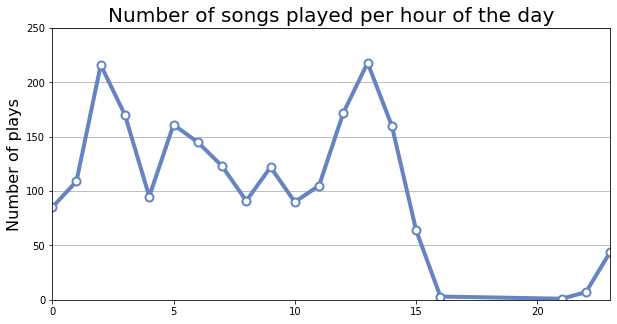

In [59]:
hour_counts = scrobbles_month['hour'].value_counts().sort_index()
ax = hour_counts.plot(kind='line', figsize=[10, 5], linewidth=4, alpha=1, marker='o', color='#6684c1', 
                      markeredgecolor='#6684c1', markerfacecolor='w', markersize=8, markeredgewidth=2)

ax.set_xlim((hour_counts.index[0], hour_counts.index[-1]))

ax.yaxis.grid(True)
ax.set_ylim((0, 250))
ax.set_ylabel('Number of plays', fontproperties=label_font)
ax.set_xlabel('', fontproperties=label_font)
ax.set_title('Number of songs played per hour of the day', fontproperties=title_font)

plt.show()

-----

## Daily Songs Listened To

In [60]:
# how many songs did I listen to per day?
daily_counts = scrobbles['date'].value_counts().sort_index()
print('{:,} total days of music listening'.format(len(daily_counts)))
daily_counts.tail(10)

1,351 total days of music listening


2020-12-06    62
2020-12-08    53
2020-12-09    49
2020-12-10    44
2020-12-11    77
2020-12-12    16
2020-12-13    39
2020-12-14    56
2020-12-15    41
2020-12-16    22
Name: date, dtype: int64

In [61]:
daily_counts.to_csv("data/lastfm_daily_listens.csv")

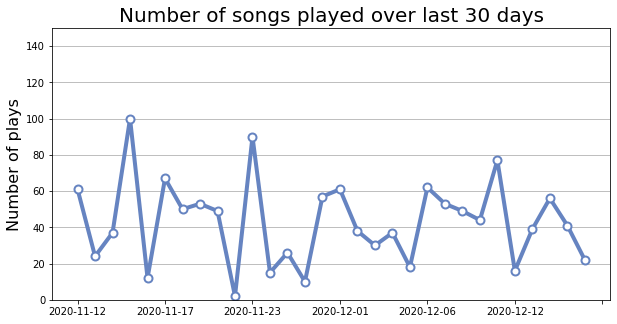

In [62]:
dataset = daily_counts.tail(30)
ax = dataset.plot(kind='line', figsize=[10, 5], linewidth=4, alpha=1, marker='o', color='#6684c1', 
                      markeredgecolor='#6684c1', markerfacecolor='w', markersize=8, markeredgewidth=2)

# ax.set_xlim((dataset.index[0], dataset.index[-1]))

ax.yaxis.grid(True)
ax.set_ylim((0, 150))
ax.set_ylabel('Number of plays', fontproperties=label_font)
ax.set_xlabel('', fontproperties=label_font)
ax.set_title('Number of songs played over last 30 days', fontproperties=title_font)

plt.show()

-----

## Hourly Songs Listened To

In [63]:
hourly = scrobbles.groupby(['date', 'hour']).size()

In [64]:
hourly.tail(30)

date        hour
2020-12-12  12       2
            13       2
2020-12-13  1        2
            3        5
            4        2
            5        5
            6        9
            7        9
            12       3
            13       3
            14       1
2020-12-14  11       4
            12      12
            13      14
            14      13
            23      13
2020-12-15  0        8
            1        7
            8        9
            9        1
            10       5
            11       1
            12       2
            13       5
            14       3
2020-12-16  1        5
            3        1
            4        4
            6        5
            7        7
dtype: int64

In [65]:
hourly.to_csv("data/hourly_song_counts.csv")